# Task 2 - QOSF Screening Tasks (cohort3)

## Problem Statement

The bit-flip code and the sign-flip code are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

1.	Build the simple circuit to prepare the Bell state.

2.	Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but   must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).

3.	Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!

4.	Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.

<br> <hr>

# Solution


#### The solution has been divided into the following sections:
<ul> <li> <a href='#imports'> Environment details and general configuration </a> </li> </ul>
<ol>
    <li> <a href='#1'> Bell State</a> </li>
    <li> <a href="#2"> Adding Errors</a>
        <ul>
            <li> <a href="#2.1"> Adding the I-Gate</a> </li>
            <li> <a href="#2.2"> Adding the X-Gate</a> </li>
            <li> <a href="#2.3"> Adding the Z-Gate</a> </li>
            <li> <a href="#2.4"> Conclusion</a> </li>
        </ul>
    </li>
    <li> <a href="#3">Encoding for Errors</a>
         <ul>
            <li> <a href="#3.1"> Bit-Flip Code</a> </li>
            <li> <a href="#3.2"> Sign-Flip Code</a> </li>
            <li> <a href="#3.3"> Shor Code</a> </li>
            <li> <a href="#3.4"> Approach </a>
                <ul>
                    <li> <a href="#3.4.1"> Function for encoding the qubits for possible errors</a> </li>
                    <li> <a href="#3.4.2"> Function for decoding the encoded qubits</a> </li>
                    <li> <a href="#3.4.3"> Simulating sign-flip error at Q0 and bit-flip error at Q1 </a> </li>
                </ul> </li> </ul> </li>
    <li> <a href="#4">Measurement and Results</a> </li>
    <li> <a href="#5"> Conclusion</a> </li>
    <li> <a href="#6">References</a> </li>
 </ol>
 
 <br>
 
 <a id='imports'></a>
 
### Environment details and general configuration: 


In [116]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [117]:
%matplotlib inline

#Importing standard Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit_textbook.tools import array_to_latex

print("Standard Qiskit Libraries Successfuly Imported.")

Standard Qiskit Libraries Successfuly Imported.


<a id='1'></a>

## 1. Bell State

_The_ _Bell_ _State_ has **50%** probability of being measured in the state $|00\rangle$, and **50%** chance of being measured in the state $|11\rangle$.

Qubits Q0 & Q1 are used to build the Bell State.
    

1. Hadamard Gate is applied to Q0. So, $$ Q0= H|0\rangle = |+\rangle = \tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$$$$Q1= |0\rangle$$This produces the state $|0\rangle \otimes |{+}\rangle = |0{+}\rangle$ :
$$
|0{+}\rangle = \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle)
$$


2. The CNOT Gate is applied to both Q0 and Q1. We have the final state as:

$$
\text{CNOT}|0{+}\rangle = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
$$ 

So, the final circuit will be in Bell State as the probability of being measured in the state $|00\rangle$ is $\tfrac{1}{2}$ or 50%, and the probability of being measured in the state $|11\rangle$ is $\tfrac{1}{2}$ i.e., 50%.

In Qiskit, Bell Sate is given as:

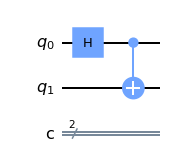

In [118]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(0)     # Hadamard Gate at Q0
                 # No Gate to Q1
circuit.cx(0,1)  # CNOT Gate to Q0 & Q1

circuit.draw() # Draw the circuit

In [119]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(circuit,backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Statevector = }") # Write state vector

<IPython.core.display.Math object>

The state vector is same as: $$\tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

Hence, the state has 50% probability of being measured in the state $|00\rangle$, and 50% chance of being measured in the state $|11\rangle$. 

Also, it has **0%** chance of being measured in the states $|01\rangle$ or $|10\rangle$. This can be shown by plotting a histogram of the probabilities of the outcomes of the circuit.

		 {'00': 492, '11': 532}


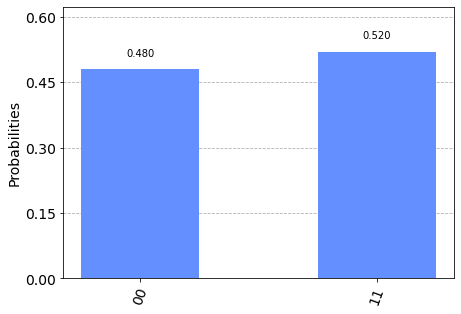

In [120]:
# Create a Quantum Circuit
meas = QuantumCircuit(2, 2)
meas.measure(range(2), range(2))

qc = circuit + meas

backend_sim = Aer.get_backend('qasm_simulator') # Use Aer's qasm_simulator

# Execute the circuit on the qasm simulator.
job_sim = execute(qc, backend_sim, shots=1024) # The number of repeats of the circuit is 1024
result_sim = job_sim.result() # Grab the results from the job.

counts = result_sim.get_counts(qc)
print("\t\t", counts)

plot_histogram(counts) # Plot Histogram for Bell State

<a id='2'></a>

## 2. Adding Errors

The errors are to be added right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. Error gate is a 1 qubit unitary with a certain probability, which can be:
1. The I-Gate (identity error)
2. The X-Gate (bit-flip error) 
3. The Z-Gate (sign-flip error)

<br>

<a id='2.1'></a>

### 2.1 Adding the I-Gate (Identity Error)

The I-gate has no effect on the qubits. It is represented by the Identity matrix:

$$ I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $$

<br> <br>

<a id='2.1.1'></a>

#### 2.1.1 Adding identity error to qubit Q0

The I-gate will not change Q0. This can also be shown by the state vector of the circuit simulated with identity error at Q0 before CNOT.


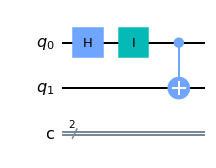

In [121]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after error gate

circuit.i(0) # Add Identity Error to Q0

circuit.cx(0,1) # CNOT Gate to Q0 & Q1 for Bell State

circuit.draw()

In [122]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(circuit,backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

<a id='2.1.1'></a>

#### 2.1.2 Adding identity error to qubit Q1
The I-gate will not change Q1. This can also be shown by the state vector of the circuit simulated with identity error at Q1 before CNOT.

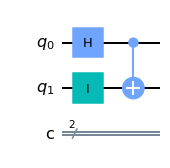

In [123]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after error gate

circuit.i(1) # Add Identity Error to Q1

circuit.cx(0,1) # CNOT Gate to Q0 & Q1 for Bell State

circuit.draw()

In [124]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(circuit,backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

<a id='2.2'></a>

### 2.2 Adding the X-Gate (Bit-Flip Error)

The X-gate is represented by the Pauli-X matrix:

$$ X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$$

The X-gate flips the spin of the qubit. It changes $|0\rangle$ to $|1\rangle$ and $|0\rangle$ to $|1\rangle$.

<br> <br>

<a id='2.2.1'></a>

#### 2.2.1 Adding bit-flip error to Q0 before CNOT gate

$$ X|+\rangle = X[\tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)] = \tfrac{1}{\sqrt{2}}(X|0\rangle+X|1\rangle) = \tfrac{1}{\sqrt{2}}(|1\rangle+|0\rangle) = |+\rangle$$

So, the X-gate will not change Q0. 

This can also be shown by the state vector of the circuit simulated with bit-flip error at Q0 before CNOT.


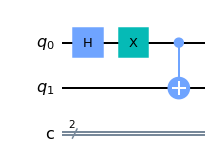

In [125]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after error gate

circuit.x(0) # Add Bit-Flip Error to Q0

circuit.cx(0,1) # CNOT Gate to Q0 & Q1 for Bell State

circuit.draw()

In [126]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(circuit,backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

<a id='2.2'></a>

#### 2.2.2 Adding bit-flip error to Q1

$$ X|0\rangle = |1\rangle$$

So, the X-gate changes the spin of Q1 or the bit of the qubit is flipped. 

This can also be shown by the state vector of the circuit simulated with bit-flip error at Q1 before CNOT.

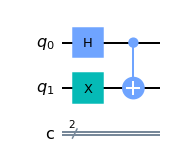

In [127]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after error gate

circuit.x(1) # Add Bit-Flip Error to Q0

circuit.cx(0,1) # CNOT Gate to Q0 & Q1 for Bell State

circuit.draw()

In [128]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(circuit,backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

<a id='2.3'></a>

### 2.3 Adding the Z-Gate (Sign-Flip Error)

The Z-gate is represented by the Pauli-Z matrix:

$$ Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} $$

The Z gate flips the phase of the qubit. It changes $|0\rangle$ to $|0\rangle$ and $|1\rangle$ to $-|1\rangle$.

<br> <br>

<a id='2.3.1'></a>

#### 2.3.1 Adding sign-flip error to Q0

$$ Z|+\rangle = Z[\tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)] = \tfrac{1}{\sqrt{2}}(Z|0\rangle+Z|1\rangle) = \tfrac{1}{\sqrt{2}}(|0\rangle-|1\rangle) = |-\rangle$$

So, the Z gate changes the phase of Q0 or the sign of the superposition is flipped. 

This can also be shown by the state vector of the circuit simulated with sign-flip error at Q0 before CNOT.

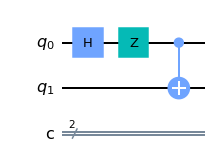

In [129]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after error gate

circuit.z(0) # Add Bit-Flip Error to Q0

circuit.cx(0,1) # CNOT Gate to Q0 & Q1 for Bell State

circuit.draw() # Draw the circuit

In [130]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(circuit,backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>


<a id='2.3.2'></a>

#### 2.3.2 Adding sign-flip error to Q1
$$Z|0\rangle = |0\rangle$$
So, the Z gate will not change Q1. 

This can also be shown by the state vector of the circuit simulated with sign-flip error at Q1 before CNOT.

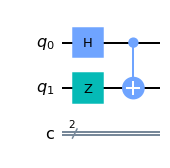

In [131]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after error gate

circuit.z(1) # Add Sign-Flip Error to Q1

circuit.cx(0,1) # CNOT Gate to Q0 & Q1 for Bell State

circuit.draw() # Draw the circuit

In [132]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(circuit,backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

<a id='2.4'></a>

### 2.4 Conclusion

We have analysed the effect of the different errors on qubits Q0 and Q1.

1. Identity error does not change the state vector of the two qubits.
2. Bit-flip error has no effect on qubit Q0, however it flips the spin of qubit Q1.
3. Sign-flip error changes the phase of qubit Q0, however it does not change Q1.

<a id='3'></a>

## 3. Encoding for Errors

The bit-flip code and the sign-flip code can be used for encoding the qubits to fix errors.

<a id='3.1'></a>

### 3.1 Bit-Flip Code
**Encoding:** To encode the qubit for bit-flip error, two ancillary qubits are required. CNOT gate is applied to these ancillary with the main qubit control.

**Decoding:** We encode the encoded qubit again i.e., CNOT gate is applied to these ancillary with the main qubit as control and finally apply Toffoli gate to all the qubits to decode the main qubit.

<a id='3.2'></a>

### 3.2 Sign-Flip Code
**Encoding:** To encode the qubit for sign-flip error, two ancillary qubits are required. H-gate is applied to the main qubit as well as the ancillary qubits. Finaly, CNOT gate is applied to these ancillary with the main qubit control.

**Decoding:** For decoding the encoded qubit, CNOT gate is applied to the ancillary with the main qubit control. Then, H-gate is applied to the main qubit as well as the ancillary qubits. Finally, Toffoli gate is applied to all the qubits to decode the main qubit.

<br>

<a id='3.3'></a>

### 3.3 Shor Code

It is possible to correct for both types of errors using one code i.e., **the Shor code**. With the Shor code, a qubit state ${\displaystyle |\psi \rangle =\alpha _{0}|0\rangle +\alpha _{1}|1\rangle }|\psi \rangle =\alpha _{0}|0\rangle +\alpha _{1}|1\rangle$  will be transformed into the product of 9 qubits ${\displaystyle |\psi '\rangle =\alpha _{0}|0_{S}\rangle +\alpha _{1}|1_{S}\rangle }|\psi '\rangle =\alpha _{0}|0_{S}\rangle +\alpha _{1}|1_{S}\rangle$. 

**Encoding:** The main qubit is encoded using <a href="#3.1">Bit-Flip Code</a> and then all the qubits (the main qubit and the ancillary qubits of Bi-Flip) are encoded using <a href="#3.2">Sign-Flip Code</a>.

**Decoding:** For decoding the encoded qubit, the main qubit and the ancillary qubits of Bit-Flip code are decoded using Sign-Flip Code. Finally, the main qubit is decoded using Bit-Flip Code.

<br>

<a id='3.4'></a>

### 3.4 Approach

<ol>
    <li>We can encode both the qubits i.e., Q0 and Q1 using the Shor's code. In this case, 16 ancillary qubits will be required (i.e., 8 qubits for each qubit to be encoded).</li>   
    <li> As the errors are applied before the CNOT Gate in Bell State, the encoding need to be done before the CNOT gate.
        <ul>
            <li> Q0 is changed by sign-flip errors only. The identity errors and bit-flip errors do not change it. Therefore, sign-flip code can be used to encode Q0. </li>
            <li> Q1 is changed by bit-flip errors only. The identity errors and sign-flip errors do not change it. Therefore, bit-flip code can be used to encode Q1. </li>
            </ul>
            So, the other approach for encoding the error can be encoding Q0 for sign-flip error and Q1 for bit-flip error. Hence, all the possible errors (sign-flip and bit-flip) in the two qubits can be fixed.
        For this, only 4 ancillary qubits will be required and lesser number of gates will be needed. So this approach has been used to encode Q0 and Q1 before CNOT Gate is applied.
         </li> </ol>

<br><br>
The functions given below will be used in the encoding and decoding process.

In [133]:
def CNOT_ancillary(q,x,y): # CNOT Gate to ancillary qubits x, y; with q as control qubit
    circuit.cx(q, x)
    circuit.cx(q, y)

def H_all(q,x,y): # Hadamard Gate to qubits q, x, y
    circuit.h(q)
    circuit.h(x)
    circuit.h(y)

<a id='3.4.1'></a>

#### 3.4.1 Function for encoding the qubits for possible errors

In [134]:
def encode(): # Encoding for possible errors
    
    # Encoding Q0 for Phase Flip Error #
    circuit.barrier()
    CNOT_ancillary(0,4,5) # Apply CNOT Gate to ancillary qubits Q4, Q5 with Q0 as control qubit
    H_all(0,4,5) # Apply Hadamard Gate to Q0 and ancillary qubits Q4, Q5
    
    # Encoding Q1 for Bit Flip Error #
    circuit.barrier()
    CNOT_ancillary(1,2,3) # Apply CNOT Gate to ancillary qubits Q2, Q3 with Q1 as control qubit

<a id='3.4.2'></a>

#### 3.4.2 Function for decoding the encoded qubits

In [135]:
def decode(): # Decoding the encoded qubits
    
    # Decoding Q0 for Phase Flip Error #
    circuit.barrier()
    H_all(0,4,5) # Apply Hadamard Gate to Q0 and ancillary qubits Q4, Q5
    CNOT_ancillary(0,4,5) # Apply CNOT Gate to ancillary qubits Q4, Q5 with Q0 as control qubit
    circuit.ccx(4,5,0) # Toffoli Gate for decoding Q0
    
    # Decoding Q1 for Bit Flip Error #
    circuit.barrier()
    CNOT_ancillary(1,2,3) # Apply CNOT Gate to ancillary qubits Q2, Q3 with Q1 as control qubit
    circuit.ccx(2,3,1) # Toffoli Gate for decoding Q1

<a id='3.4.3'></a>

#### 3.4.3 Simulating sign-flip error at Q0 and bit-flip error at Q1

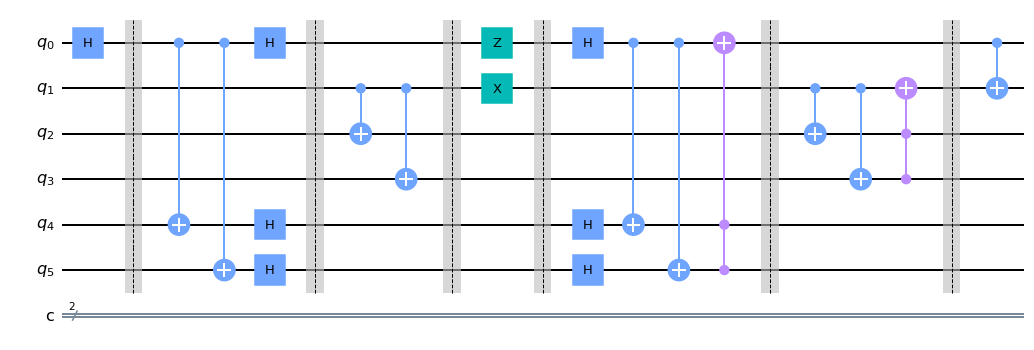

In [136]:
qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State is formed by Q0 and Q1 ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after encoding & decoding them for phase & bit flip errors respectively  

encode() # User-defined function for encoding the qubits

##### Simulating Errors #####
circuit.barrier()
circuit.z(0) # Simulating Q0 for Phase Flip Error
circuit.x(1) # Simulating Q1 for Bit Flip Error

decode() # User defined function for decoding

circuit.barrier()
circuit.cx(0,1) # CNOT Gate at Q0 and Q1 for Bell State

circuit.draw() # Draw the circuit

	 Sign-flip error at Q0 & Bit-flip error at Q1 
		 {'00': 509, '11': 491}


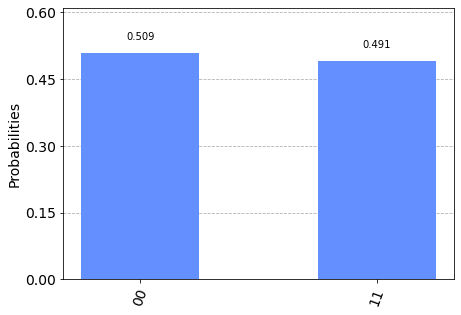

In [137]:
# Create a Quantum Circuit
meas = QuantumCircuit(6, 2)
meas.measure(range(2), range(2))
qc = circuit + meas
backend_sim = Aer.get_backend('qasm_simulator') # Use Aer's qasm_simulator

# Execute the circuit on the qasm simulator.
job_sim = execute(qc, backend_sim, shots=1000) # The number of repeats of the circuit is 1000
result_sim = job_sim.result() # Grab the results from the job.

counts = result_sim.get_counts(qc)
print("\t Sign-flip error at Q0 & Bit-flip error at Q1 \n\t\t", counts)

plot_histogram(counts)

When histogram of the probabilities of the outcomes of the final state is plotted, we observe that the state has approximately 50% probability of being measured in the state $|00\rangle$, and 50% chance of being measured in the state $|11\rangle$. So, the encoding fixes sign-flip error at Q0 and bit-flip error at Q1 before CNOT gate of Bell state.

<br>

<a id='4'></a>

## 4. Measurement and Results

Now, the code is simulated with combination of unitary errors (I-gate, X-gate, Z-gate) at Q0 & Q1 with different probabilities

Simulation with combination of unitary errors at Q0 & Q1 with different probabilities: {'00': 502, '11': 498}


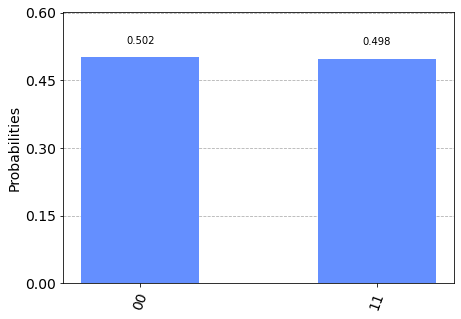

In [140]:
import numpy

qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#### Bell State is formed by Q0 and Q1 ####
circuit.h(0) # Hadamard Gate at Q0
             # No Gate to Q1
             # CNOT Gate to Q0 & Q1 after encoding & decoding them for phase and bit flip errors respectively

encode()

##### Adding Errors Probabilistically #####
circuit.barrier()

error_prob=(0.3,0.35,0.35) # error_prob: tuple giving probability of (I, X, Z) error gates
                           #            (the 3 elements of the tuple must be non_zero & sum to 1)

i_error = i.to_instruction()
x_error = x.to_instruction()
z_error = z.to_instruction()

unitary_error = numpy.random.choice([i_error, x_error, z_error], 2, p=error_prob)
circuit.append(error_gates[0],[0])
circuit.append(error_gates[1],[1])
###########################################

decode()

circuit.barrier()
circuit.cx(0,1) # CNOT Gate at Q0 and Q1 for Bell State

# Create a Quantum Circuit
meas = QuantumCircuit(6, 2)
meas.measure(range(2), range(2))
qc = circuit + meas
backend_sim = Aer.get_backend('qasm_simulator') # Use Aer's qasm_simulator

# Execute the circuit on the qasm simulator.
job_sim = execute(qc, backend_sim, shots=1000) # The number of repeats of the circuit is 1000
result_sim = job_sim.result() # Grab the results from the job.

counts = result_sim.get_counts(qc)
print("Simulation with combination of unitary errors at Q0 & Q1 with different probabilities:", counts)

plot_histogram(counts)

We can change the tuple error_prob to change the probabilities of (I, X, Z) error gates. The measurement of final state for  different values of probabilities comes out to be approximately 50% for both the states $|00\rangle$ and $|11\rangle$.

<a id='5'></a>

# 5. Conclusion

Measurements are taken and analysed after for unitary errors with random probabilities. The measurement of final state for the different cases shows that the probability of the state $|00\rangle$ is approximately 50%, and 50% chance of being measured in the state $|11\rangle$ is also roughly 50%. 

Hence, the code works well for all the cases and is able to fix the errors occuring at Q0 and Q1 before the CNOT gate and  can be used to encode and decode each of the two qubits, in such a way that all the possible choices for the error gates (I-gate, X-gate and Z-gate) applied before CNOT gate of the Bell State, occurring on the logical qubits, can be detected and fixed.

<br> <hr> <br>
<a id='6'></a>

## References

<ul> 
    <li> <a href= "https://en.wikipedia.org/wiki/Quantum_error_correction#:~:text=Peter%20Shor's%209%2Dqubit,errors%20in%20a%20single%20qubit.&text=Raymond%20Laflamme%20and%20collaborators%20found,property%20of%20being%20fault%2Dtolerant">Quantum error correction - Wikipedia </a> </li>
    <li> <a href= "https://qiskit.org/" >Qiskit </a> </li>

</ul>

<br>